<a href="https://colab.research.google.com/github/gowrisankar393/vaylen-transitlk/blob/Multi-Sensor-Fusion-Crash-Detection/TransitLK_MSFCD_CVP_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Multi Sensor Fusion Crash Detection - Computer Vision Model**

##**Setup and Load Data**

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")

#mount drive
from google.colab import drive
drive.mount('/content/drive')

#dataset path
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/TransitLK_MSFCD_CVM.v2-2.folder'

print(f"\nDataset path: {BASE_PATH}")

TensorFlow Version: 2.19.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Dataset path: /content/drive/MyDrive/Colab Notebooks/TransitLK_MSFCD_CVM.v2-2.folder


##**Exploratory Data Analysis**

Exploratory Data Analysis

Dataset structure found:
  train: Crash=429, Normal=219, Total=648
  test: Crash=61, Normal=32, Total=93
  valid: Crash=124, Normal=62, Total=186

Dataset loaded: 927 images
   split  label                                           filename
0  train  crash    318_png.rf.b11a4c6faf3ea60ecdcddc22a8845f33.jpg
1  train  crash    330_png.rf.9b8e75b391f8c951498d478967bf6591.jpg
2  train  crash    301_png.rf.257135aabe3487592e77510630717358.jpg
3  train  crash  frame_0128_jpg.rf.ae60306db3d129879165e8eb4e9a...
4  train  crash    324_png.rf.67d1a28bae58af6c644adcfab741b017.jpg

1. Class Distribution (Crash vs Normal):
label
crash     614
normal    313
Name: count, dtype: int64

Crash rate: 66.24%


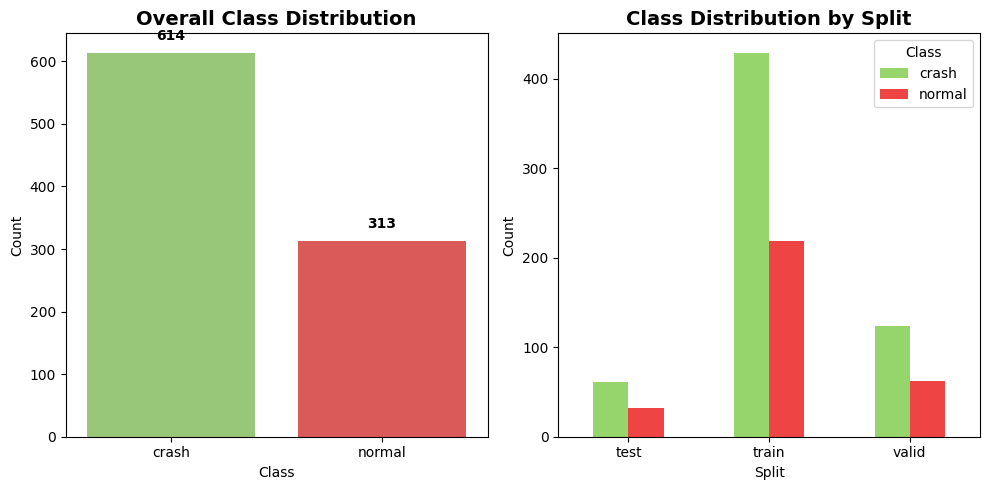


2. Sample Images:


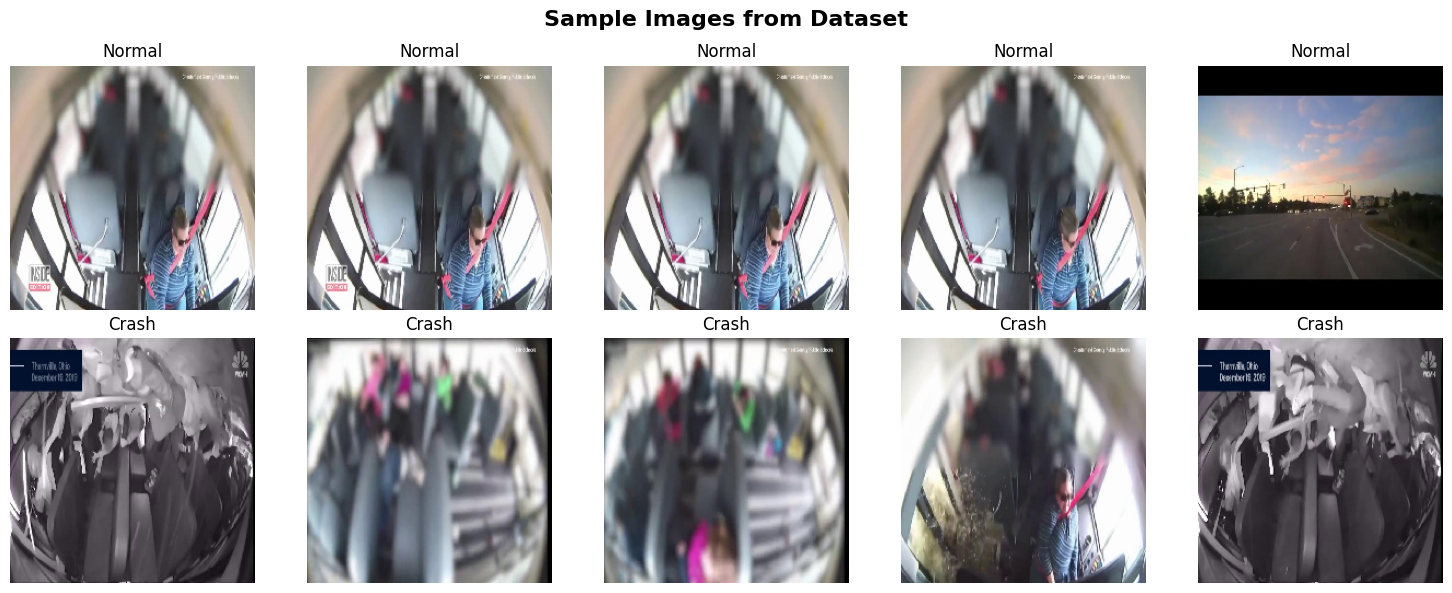

In [13]:
print("Exploratory Data Analysis\n")

#check if path exists and list structure
import os
if os.path.exists(BASE_PATH):
    print("Dataset structure found:")
    for split in ['train', 'test', 'valid']:
        split_path = os.path.join(BASE_PATH, split)
        if os.path.exists(split_path):
            crash_dir = os.path.join(split_path, 'crash')
            normal_dir = os.path.join(split_path, 'normal')
            crash_count = len([f for f in os.listdir(crash_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]) if os.path.exists(crash_dir) else 0
            normal_count = len([f for f in os.listdir(normal_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]) if os.path.exists(normal_dir) else 0
            print(f"  {split}: Crash={crash_count}, Normal={normal_count}, Total={crash_count + normal_count}")
else:
    print("Path not found! Please check your dataset location.")

#create dataframe for analysis
data = []
for split in ['train', 'test', 'valid']:
    for label in ['crash', 'normal']:
        folder = os.path.join(BASE_PATH, split, label)
        if os.path.exists(folder):
            files = [f for f in os.listdir(folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
            for f in files:
                data.append({'split': split, 'label': label, 'filename': f})

df = pd.DataFrame(data)
print(f"\nDataset loaded: {len(df)} images")
print(df.head())

#class distribution analysis
print("\n1. Class Distribution (Crash vs Normal):")
class_counts = df['label'].value_counts()
print(class_counts)
print(f"\nCrash rate: {class_counts.get('crash', 0)/len(df):.2%}")

#visualize class distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=class_counts.index, y=class_counts.values, palette=['#96d46c','#ef4444'])
plt.title('Overall Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 20, str(v), ha='center', fontweight='bold')

#distribution by split
plt.subplot(1, 2, 2)
split_counts = df.groupby(['split', 'label']).size().unstack(fill_value=0)
split_counts.plot(kind='bar', ax=plt.gca(), color=['#96d46c', '#ef4444'])
plt.title('Class Distribution by Split', fontsize=14, fontweight='bold')
plt.xlabel('Split')
plt.ylabel('Count')
plt.legend(title='Class')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

#show sample images
print("\n2. Sample Images:")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')

for idx, label in enumerate(['normal', 'crash']):
    label_df = df[df['label'] == label]
    if len(label_df) > 0:
        sample_files = label_df.sample(min(5, len(label_df)))['filename'].values
        for i, filename in enumerate(sample_files):
            #get full path (assuming from train split for samples)
            img_path = os.path.join(BASE_PATH, 'train', label, filename)
            if not os.path.exists(img_path):
                #try other splits if not in train
                for split in ['valid', 'test']:
                    img_path = os.path.join(BASE_PATH, split, label, filename)
                    if os.path.exists(img_path):
                        break

            if os.path.exists(img_path):
                img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
                axes[idx, i].imshow(img)
                axes[idx, i].set_title(f'{label.capitalize()}')
                axes[idx, i].axis('off')

plt.tight_layout()
plt.show()

##**Data Preprocessing and Configuration**

In [14]:
print("Data Preprocessing & Configuration")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

#parameters
params = {
    'target_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'class_mode': 'binary',
    'seed': 42
}

print(f"\nImage Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")

#check class distribution in training set specifically
train_crash = len(os.listdir(os.path.join(BASE_PATH, 'train', 'crash')))
train_normal = len(os.listdir(os.path.join(BASE_PATH, 'train', 'normal')))
print(f"\nTraining set - Crash: {train_crash}, Normal: {train_normal}")

if train_crash > 0 and train_normal > 0:
    imbalance_ratio = train_normal / train_crash
    print(f"Imbalance Ratio (Normal:Crash): {imbalance_ratio:.2f}:1")

    if imbalance_ratio > 1.5:
        print("Dataset is imbalanced. Will use class weights.")
        use_class_weights = True
    else:
        use_class_weights = False
else:
    use_class_weights = False

Data Preprocessing & Configuration

Image Size: (224, 224)
Batch Size: 32

Training set - Crash: 429, Normal: 219
Imbalance Ratio (Normal:Crash): 0.51:1


##**Handle CLass Imbalance**

In [15]:
print("Handling Class Imbalance")

if use_class_weights:
    #calculate class weights (inverse the frequency)
    total = train_crash + train_normal
    weight_for_crash = (1 / train_crash) * (total / 2.0)
    weight_for_normal = (1 / train_normal) * (total / 2.0)

    class_weights = {0: weight_for_normal, 1: weight_for_crash}
    print(f"Class Weights: {class_weights}")
else:
    class_weights = None
    print("No class weights needed (balanced dataset)")

Handling Class Imbalance
No class weights needed (balanced dataset)


##**Data Generation**

In [16]:
print("Creating Data Generators")

#training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

#validation/test data - only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

#create generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'train'),
    **params,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'valid'),
    **params,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'test'),
    **params,
    shuffle=False
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

#verify class indices
print(f"\nClass indices: {train_generator.class_indices}")

Creating Data Generators
Found 648 images belonging to 2 classes.
Found 186 images belonging to 2 classes.
Found 93 images belonging to 2 classes.

Training samples: 648
Validation samples: 186
Test samples: 93

Class indices: {'crash': 0, 'normal': 1}


##**Building Model Using Transfer Learning**

In [17]:
print("Building Model")

def build_model():
    #MobileNetV2 is lightweight and good for edge deployment as we are using phone as a central
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        alpha=1.0
    )

    #freeze base model initially (similar to training on features first)
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)  #binary classification

    model = Model(inputs, outputs)
    return model, base_model

model, base_model = build_model()

#compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

#model architecture
print("\nModel Architecture:")
model.summary()

Building Model

Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,713 (9.26 MB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

#**Model Training - Phase 1**

In [18]:
print("Model Training - Phase 1")

callbacks_phase1 = [
    EarlyStopping(
        monitor='val_auc',
        patience=10,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ModelCheckpoint(
        'crash_model_phase1.h5',
        save_best_only=True,
        monitor='val_auc',
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

history1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=100,
    callbacks=callbacks_phase1,
    class_weight=class_weights,
    verbose=1
)

print("Model Training Complete!")

Model Training - Phase 1
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5397 - auc: 0.5602 - loss: 0.8540
Epoch 1: val_auc improved from -inf to 0.86346, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 210s 10s/step - accuracy: 0.5405 - auc: 0.5622 - loss: 0.8527 - val_accuracy: 0.6875 - val_auc: 0.8635 - val_loss: 0.5780 - learning_rate: 1.0000e-04
Epoch 2/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7188 - auc: 0.7891 - loss: 0.5896
Epoch 2: val_auc improved from 0.86346 to 0.87153, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 980ms/step - accuracy: 0.7188 - auc: 0.7891 - loss: 0.5896 - val_accuracy: 0.6938 - val_auc: 0.8715 - val_loss: 0.5728 - learning_rate: 1.0000e-04
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6922 - auc: 0.7764 - loss: 0.6340
Epoch 3: val_auc improved from 0.87153 to 0.95172, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.6916 - auc: 0.7758 - loss: 0.6348 - val_accuracy: 0.7437 - val_auc: 0.9517 - val_loss: 0.4776 - learning_rate: 1.0000e-04
Epoch 4/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.5938 - auc: 0.6729 - loss: 0.8472
Epoch 4: val_auc improved from 0.95172 to 0.95206, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 459ms/step - accuracy: 0.5938 - auc: 0.6729 - loss: 0.8472 - val_accuracy: 0.7437 - val_auc: 0.9521 - val_loss: 0.4749 - learning_rate: 1.0000e-04
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7359 - auc: 0.8497 - loss: 0.5389
Epoch 5: val_auc improved from 0.95206 to 0.97928, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7359 - auc: 0.8498 - loss: 0.5385 - val_accuracy: 0.8250 - val_auc: 0.9793 - val_loss: 0.3967 - learning_rate: 1.0000e-04
Epoch 6/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 18s 957ms/step - accuracy: 0.8125 - auc: 0.9091 - loss: 0.4529
Epoch 6: val_auc improved from 0.97928 to 0.98118, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 397ms/step - accuracy: 0.8125 - auc: 0.9091 - loss: 0.4529 - val_accuracy: 0.8375 - val_auc: 0.9812 - val_loss: 0.3925 - learning_rate: 1.0000e-04
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7147 - auc: 0.8447 - loss: 0.5605
Epoch 7: val_auc improved from 0.98118 to 0.99776, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7166 - auc: 0.8456 - loss: 0.5581 - val_accuracy: 0.9062 - val_auc: 0.9978 - val_loss: 0.3365 - learning_rate: 1.0000e-04
Epoch 8/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7812 - auc: 0.8947 - loss: 0.4316
Epoch 8: val_auc improved from 0.99776 to 0.99787, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 445ms/step - accuracy: 0.7812 - auc: 0.8947 - loss: 0.4316 - val_accuracy: 0.9125 - val_auc: 0.9979 - val_loss: 0.3346 - learning_rate: 1.0000e-04
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7905 - auc: 0.8985 - loss: 0.4697
Epoch 9: val_auc improved from 0.99787 to 0.99910, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7911 - auc: 0.8982 - loss: 0.4693 - val_accuracy: 0.9187 - val_auc: 0.9991 - val_loss: 0.2978 - learning_rate: 1.0000e-04
Epoch 10/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7188 - auc: 0.8984 - loss: 0.5995
Epoch 10: val_auc did not improve from 0.99910
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 440ms/step - accuracy: 0.7188 - auc: 0.8984 - loss: 0.5995 - val_accuracy: 0.9187 - val_auc: 0.9991 - val_loss: 0.2973 - learning_rate: 1.0000e-04
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8186 - auc: 0.9075 - loss: 0.4074
Epoch 11: val_auc improved from 0.99910 to 1.00000, saving model to crash_model_phase1.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8186 - auc: 0.9078 - loss: 0.4074 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.2706 - learning_rate: 1.0000e-04
Epoch 12/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 18s 987ms/step - accuracy: 0.7812 - auc: 0.9203 - loss: 0.5322
Epoch 12: val_auc did not improve from 1.00000
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 321ms/step - accuracy: 0.7812 - auc: 0.9203 - loss: 0.5322 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.2683 - learning_rate: 1.0000e-04
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8309 - auc: 0.9195 - loss: 0.3973
Epoch 13: val_auc did not improve from 1.00000
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8307 - auc: 0.9197 - loss: 0.3966 - val_accuracy: 0.9500 - val_auc: 1.0000 - val_loss: 0.2327 - learning_rate: 1.0000e-04
Epoch 14/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 18s 995ms/step - accuracy: 0.9062 - auc: 0.9459 - loss: 0.3511
Epoch 14: val_auc did not improve from 1.00000
20/20 ━━━━━━━━━━━━━━━━━━━━ 

#**Model Training - Phase 2 (Fine Tuning)**

In [19]:
print("Fine Tuning Model")

#unfreeze top 30 layers
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

#recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5), #10x lower for fine tuning
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print(f"Trainable variables: {len(model.trainable_variables)}")

callbacks_phase2 = [
    EarlyStopping(
        monitor='val_auc',
        patience=15,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ModelCheckpoint(
        'crash_model_final.h5',
        save_best_only=True,
        monitor='val_auc',
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-8,
        verbose=1
    )
]

history2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    initial_epoch=len(history1.history['loss']),
    callbacks=callbacks_phase2,
    class_weight=class_weights,
    verbose=1
)

print("Training Complete!")

Fine Tuning Model
Trainable variables: 40
Epoch 22/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7713 - auc: 0.8711 - loss: 0.4793
Epoch 22: val_auc improved from -inf to 1.00000, saving model to crash_model_final.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.7712 - auc: 0.8708 - loss: 0.4805 - val_accuracy: 0.9312 - val_auc: 1.0000 - val_loss: 0.2532 - learning_rate: 1.0000e-05
Epoch 23/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7500 - auc: 0.8421 - loss: 0.4980
Epoch 23: val_auc did not improve from 1.00000
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 316ms/step - accuracy: 0.7500 - auc: 0.8421 - loss: 0.4980 - val_accuracy: 0.9312 - val_auc: 1.0000 - val_loss: 0.2522 - learning_rate: 1.0000e-05
Epoch 24/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7588 - auc: 0.8831 - loss: 0.4860
Epoch 24: val_auc did not improve from 1.00000
20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.7594 - auc: 0.8830 - loss: 0.4851 - val_accuracy: 0.9312 - val_auc: 0.9998 - val_loss: 0.2330 - learning_rate: 1.0000e-05
Epoch 25/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7812 - auc: 0.9104 - loss: 0.4037
Epoch 25: val_auc did not improve from 1.00000
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 452ms

##**Model Evaluation**

Model Evaluation


3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 8s/step

Test samples evaluated: 93

Test Accuracy: 87.10%

Classification Report:
              precision    recall  f1-score   support

       Crash       0.98      0.82      0.89        61
      Normal       0.74      0.97      0.84        32

    accuracy                           0.87        93
   macro avg       0.86      0.89      0.87        93
weighted avg       0.90      0.87      0.87        93


Confusion Matrix:
[[50 11]
 [ 1 31]]


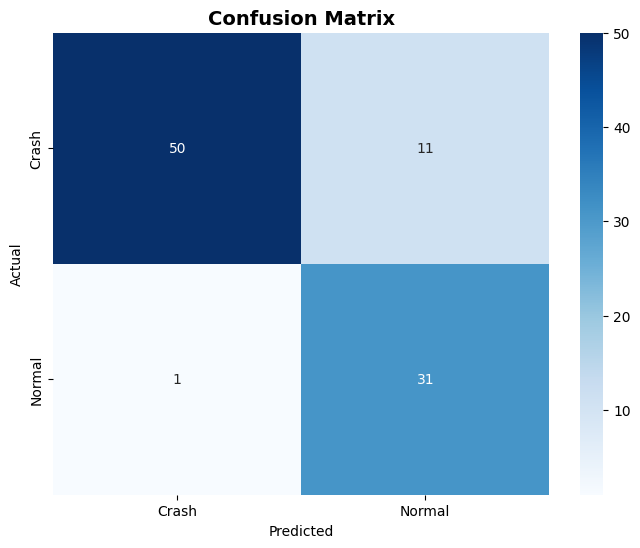

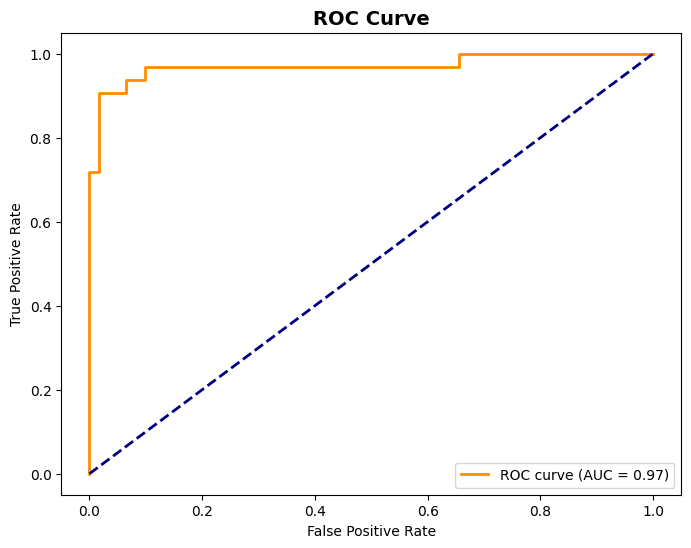

In [20]:
print("Model Evaluation")

#load best model
model = tf.keras.models.load_model('crash_model_final.h5')

#get predictions on test set
test_generator.reset()
y_pred_prob = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

#get true labels
y_true = test_generator.classes[:len(y_pred)]  # Match lengths

print(f"\nTest samples evaluated: {len(y_true)}")

#calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy:.2%}")

#classification report
print("\nClassification Report:")
target_names = ['Crash', 'Normal'] if test_generator.class_indices['crash'] == 0 else ['Normal', 'Crash']
print(classification_report(y_true, y_pred, target_names=target_names))

#confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

#visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:len(y_true)])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.show()

#**Training History**

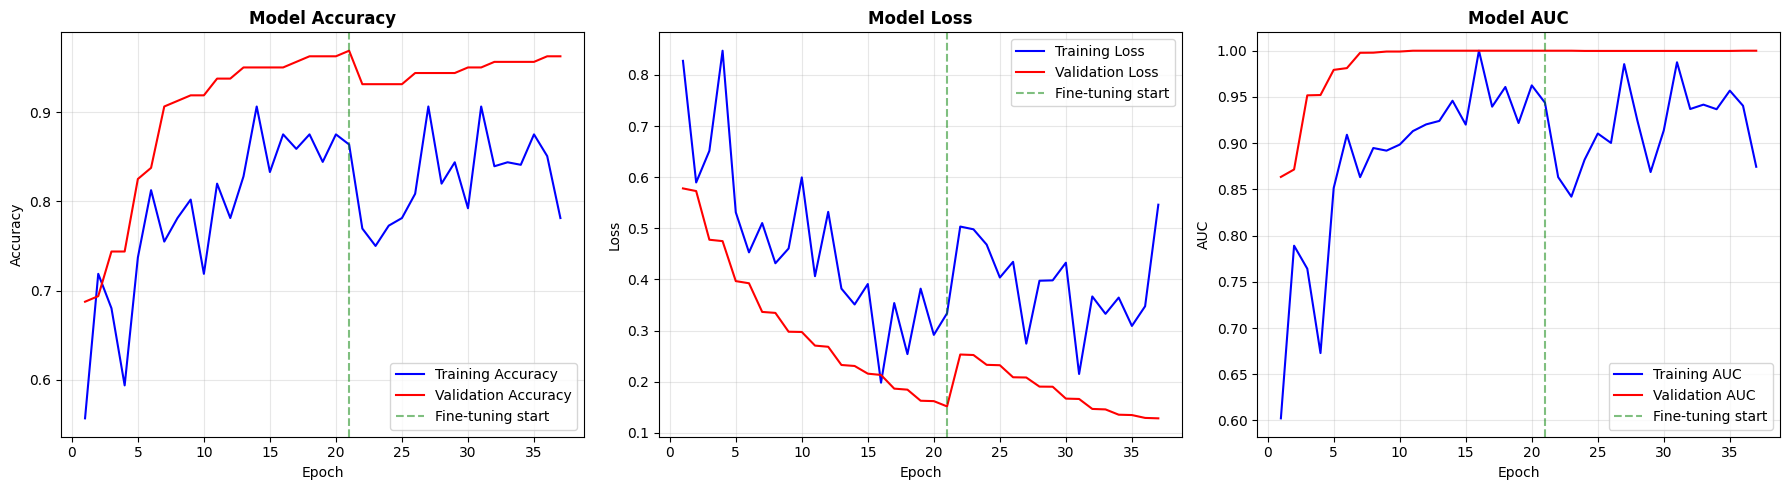

In [21]:
def plot_training(history1, history2):
    #combine histories
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    auc = history1.history['auc'] + history2.history['auc']
    val_auc = history1.history['val_auc'] + history2.history['val_auc']

    epochs = range(1, len(acc) + 1)
    phase1_epochs = len(history1.history['accuracy'])

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    #accuracy
    axes[0].plot(epochs, acc, 'b-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    axes[0].axvline(phase1_epochs, color='g', linestyle='--', alpha=0.5, label='Fine-tuning start')
    axes[0].set_title('Model Accuracy', fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    #loss
    axes[1].plot(epochs, loss, 'b-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'r-', label='Validation Loss')
    axes[1].axvline(phase1_epochs, color='g', linestyle='--', alpha=0.5, label='Fine-tuning start')
    axes[1].set_title('Model Loss', fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # AUC
    axes[2].plot(epochs, auc, 'b-', label='Training AUC')
    axes[2].plot(epochs, val_auc, 'r-', label='Validation AUC')
    axes[2].axvline(phase1_epochs, color='g', linestyle='--', alpha=0.5, label='Fine-tuning start')
    axes[2].set_title('Model AUC', fontweight='bold')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('AUC')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training(history1, history2)

##**Export Model as a Keras and Converting to TensorFlow Lite Model for Mobile Usage**

In [23]:
from google.colab import files

print("Exporting Model")

#save Keras model
model.save('TransitLK_MSFCD_CVP_TF.h5')
print("Saved as TransitLK_MSFCD_CVP_TF.h5")

#convert to TnsorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('TransitLK_MSFCD_CVP_TF.tflite', 'wb') as f:
    f.write(tflite_model)
print("Saved as TransitLK_MSFCD_CVP_TF.tflite")

#download files
files.download('TransitLK_MSFCD_CVP_TF.h5')
files.download('TransitLK_MSFCD_CVP_TF.tflite')

Exporting Model
Saved as TransitLK_MSFCD_CVP_TF.h5
Saved artifact at '/tmp/tmpjlnryems'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140094319729680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140094321677456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140095036402832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140094319732560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140095000103440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140095036403792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140095036404176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140095036401296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140095036403024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140095036400528: TensorSpec(shap

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>